In [11]:
import os

import seaborn as sns

import numpy as np
import pandas as pd
from scipy.signal import decimate
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.signal import decimate, hanning, convolve, spectrogram, lfilter, cheby2, butter, cheb2ord, hilbert
from librosa import stft, fft_frequencies, frames_to_time
import math

import warnings
warnings.filterwarnings("ignore")

In [12]:
def demon(data, fs, n_fft=1024, max_freq=35, overlap_ratio=0.5, apply_bandpass=True, bandpass_specs=None, method='abs'):
    if not isinstance(data, np.ndarray):
        raise ValueError("Input must be of type numpy.ndarray. %s was passed" % type(data))
    x = data.copy()

    first_pass_sr = 441 

    q1 = round(fs/first_pass_sr) 
    q2 = round((fs/q1)/(2*max_freq)) 

    fft_over = math.floor(n_fft-2*max_freq*overlap_ratio)

    if apply_bandpass:
        if bandpass_specs is None:
            nyq = fs/2
            wp = [1000/nyq, 2000/nyq]
            ws = [700/nyq, 2300/nyq]
            rp = 0.5
            As = 50
        elif isinstance(bandpass_specs, dict):
            try:
                fp = bandpass_specs["fp"]
                fs = bandpass_specs["fs"]

                wp = np.array(fp)/nyq
                ws = np.array(fs)/nyq
                
                rp = bandpass_specs["rs"]
                As = bandpass_specs["as"]
            except KeyError as e:
                raise KeyError("Missing %s specification for bandpass filter" % e)
        else:
            raise ValueError("bandpass_specs must be of type dict. %s was passed" % type(bandpass_specs))
        
        N, wc = cheb2ord(wp, ws, rp, As) 
        b, a = cheby2(N, rs=As, Wn=wc, btype='bandpass', output='ba', analog=True)
        x = lfilter(b, a, x, axis=0)

    if method=='hilbert':
        x = hilbert(x)
    elif method=='abs':
        x = np.abs(x) # demodulation
    else:
        raise ValueError("Method not found")

    x = decimate(x, q1, ftype='fir', zero_phase=False)
    x = decimate(x, q2, ftype='fir', zero_phase=False)

    final_fs = (fs//q1)//q2

    x /= x.max()
    x -= np.mean(x)
    sxx = stft(x,
               window=('hann'),
               win_length=n_fft,
               hop_length=(n_fft - fft_over),
               n_fft=n_fft)
    freq = fft_frequencies(sr=final_fs, n_fft=n_fft)
    time = frames_to_time(np.arange(0, sxx.shape[1]), 
                   sr=final_fs, hop_length=(n_fft - fft_over))

    sxx = np.absolute(sxx)
    
    sxx = sxx / tpsw(sxx)

    sxx, freq = sxx[8:, :], freq[8:] # ??

    return np.transpose(sxx), freq, time


In [13]:
def tpsw(signal, npts=None, n=None, p=None, a=None):
    x = np.copy(signal)
    if x.ndim == 1:
        x = x[:, np.newaxis]
    if npts is None:
        npts = x.shape[0]
    if n is None:
        n=int(round(npts*.04/2.0+1))
    if p is None:
        p =int(round(n / 8.0 + 1))
    if a is None:
        a = 2.0
    if p>0:
        h = np.concatenate((np.ones((n-p+1)), np.zeros(2 * p-1), np.ones((n-p+1))), axis=None)
    else:
        h = np.ones((1, 2*n+1))
        p = 1
    h /= np.linalg.norm(h, 1)

    def apply_on_spectre(xs):
        return convolve(h, xs, mode='full')

    mx = np.apply_along_axis(apply_on_spectre, arr=x, axis=0)
    ix = int(np.floor((h.shape[0] + 1)/2.0)) 
    mx = mx[ix-1:npts+ix-1]
    
    ixp = ix - p
    mult=2*ixp/np.concatenate([np.ones(p-1)*ixp, range(ixp,2*ixp + 1)], axis=0)[:, np.newaxis] 
    mx[:ix,:] = mx[:ix,:]*(np.matmul(mult, np.ones((1, x.shape[1])))) 
    mx[npts-ix:npts,:]=mx[npts-ix:npts,:]*np.matmul(np.flipud(mult),np.ones((1, x.shape[1]))) 
    
    indl = (x-a*mx) > 0

    x = np.where(indl, mx, x)
    mx = np.apply_along_axis(apply_on_spectre, arr=x, axis=0)
    mx=mx[ix-1:npts+ix-1,:]
    
    mx[:ix,:]=mx[:ix,:]*(np.matmul(mult,np.ones((1, x.shape[1])))) 
    mx[npts-ix:npts,:]=mx[npts-ix:npts,:]*(np.matmul(np.flipud(mult),np.ones((1,x.shape[1])))) 

    if signal.ndim == 1:
        mx = mx[:, 0]
    return mx

## Bandpass filter design

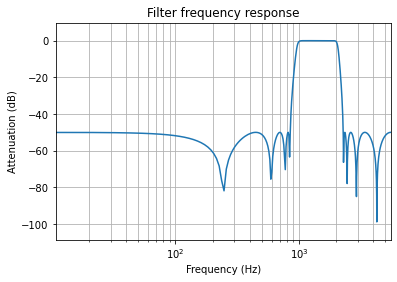

In [14]:
from scipy import signal
fs = 11025
nyq = 0.5*fs
wp = [1000/nyq, 2000/nyq]
ws = [700/nyq, 2300/nyq]
Ap = 0.5
As = 50
N, wc = signal.cheb2ord(wp, ws, Ap, As)

b, a = signal.cheby2(N, As, wc, 'bandpass')
w, h = signal.freqz(b, a)
plt.semilogx(w*fs/(2*np.pi) , 20 * np.log10(abs(h)))
plt.title('Filter frequency response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Attenuation (dB)')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.show()
plt.close()

In [15]:
import soundfile as sf
def read_audio_file(filepath):
    signal, fs = sf.read(filepath)

    return signal, fs

In [16]:
signal,fs =read_audio_file('data.wav')
fs


11025

## DEMON analysis

In [17]:
sxx, freq, time = demon(signal, fs, max_freq=35, apply_bandpass=True , bandpass_specs=None)

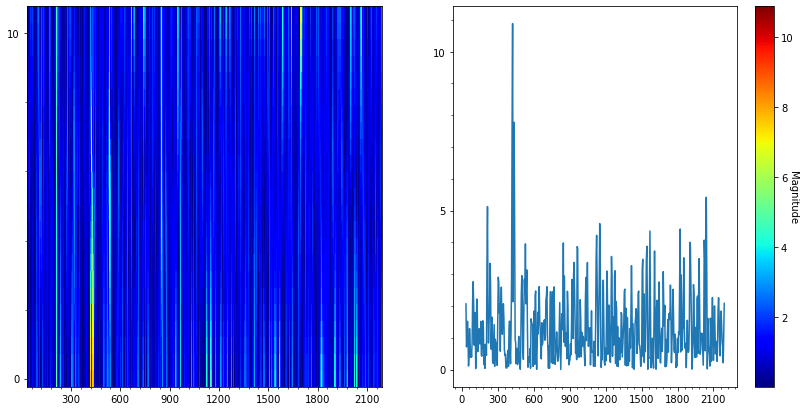

In [18]:
def plot_spectrogram(pfreq, ptime, psxx, show_rpm=True, show=True, savepath=None):
    freq, time, sxx = pfreq.copy(), ptime.copy(), psxx.copy()

    fig,axes = plt.subplots(ncols=2, figsize=(14,7))

    if show_rpm:
        freq *= 60
        xlabel = "Rotation (rpm)"
        tick_multiplier = 60
    else:
        xlabel = "Frequency (Hz)"
        tick_multiplier = 1

    cmap = axes[0].pcolormesh(freq, time, sxx, cmap='jet', vmin=np.quantile(sxx, 0.00), shading='auto',vmax=sxx.max());
    idx_freq = np.arange(0, freq.shape[0], dtype=int)
    idx_time = np.arange(0, time.shape[0], dtype=int)

    x_n_ticks = 6
    hop = idx_freq.shape[0]//x_n_ticks
    time_pos = 0

    axes[1].plot(freq, sxx[time_pos, :])


    for ax in axes:
        ax.xaxis.set_major_locator(MultipleLocator(5*tick_multiplier))
        ax.xaxis.set_minor_locator(MultipleLocator(1*tick_multiplier))
    
    axes[0].yaxis.set_major_locator(MultipleLocator(10))
    axes[0].yaxis.set_minor_locator(MultipleLocator(2))

    axes[1].yaxis.set_major_locator(MultipleLocator(5))
    axes[1].yaxis.set_minor_locator(MultipleLocator(1))

    cbar = plt.colorbar(cmap)
    cbar.ax.set_ylabel('Magnitude', rotation=270)

    if show:
        plt.show()

    if savepath is not None:
        fig.savefig(savepath)

    plt.close()

plot_spectrogram(freq, time, sxx)

## FFT - STFT 

In [19]:
import IPython.display
import librosa
from librosa import display as d, filters, segment, util

class sound:
    def __init__(self, name):
        self.signal, self.__framerate = librosa.load( name, sr=None, mono=True)
        self.__firstsignal = self.signal
    def getFrameRate(self):
        return self.__framerate
    def getFirstSignal(self):
        return self.__firstsignal
    def playFirstSignal(self):
        IPython.display.display(
            IPython.display.Audio(self.__firstsignal, rate=self.__framerate)
        )
    def play(self):
        IPython.display.display(
            IPython.display.Audio(self.signal, rate=self.__framerate)
        )
    def writeFile(self, name):
        librosa.output.write_wav(name, self.signal, self.__framerate)

Sample is loaded 


Sample signal in time domain is plotted 
Sample signal in frequency domain is plotted 


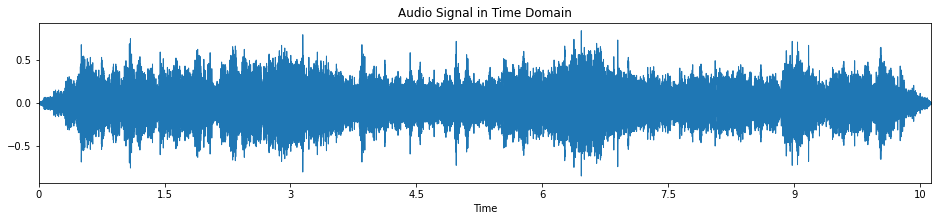

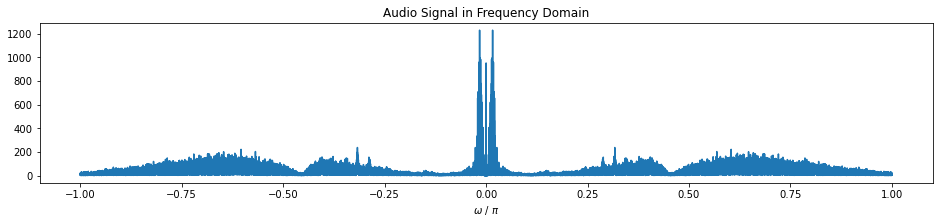

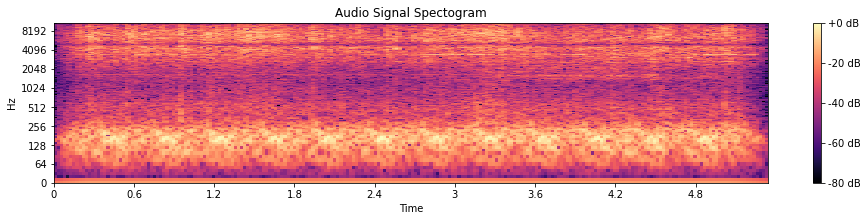

Sample signal spectogram is plotted 


In [20]:
    sample = sound('data.wav')
    print("Sample is loaded ")
    sample.play()

    plt.figure(figsize=(16, 10))
    plt.subplot(3, 1, 1)
    plt.title("Audio Signal in Time Domain")
    librosa.display.waveplot(sample.signal, sr=sample.getFrameRate())
    plt.xlabel('Time')
    print("Sample signal in time domain is plotted ")

    xw = np.fft.fftshift(np.fft.fft(sample.signal))
    w = np.linspace(-np.pi, np.pi, len(xw))
    plt.figure(figsize=(16, 10))
    plt.subplot(3, 1, 2)
    plt.title("Audio Signal in Frequency Domain")
    plt.xlabel("$\omega$ / $\pi$")
    plt.plot(w/np.pi, np.abs(xw))
    print("Sample signal in frequency domain is plotted ")

    xws = librosa.stft(sample.signal)
    plt.figure(figsize=(16, 10))
    plt.subplot(3, 1, 3)
    plt.title("Audio Signal Spectogram")
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(xws), ref=np.max),y_axis='log', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.show()
    print("Sample signal spectogram is plotted ")